In [62]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
figsize = (12, 8)

In [44]:
%matplotlib inline

## Read CSVS

In [45]:
# Read in csv data
slot_performance = pd.read_csv("../data/slot_performance.csv")
slot_performance.start_date = pd.to_datetime(slot_performance.start_date, format='%m/%d/%Y')
slot_performance.end_date = pd.to_datetime(slot_performance.end_date, format='%m/%d/%Y')

location = pd.read_csv("../data/location.csv")

In [46]:
slot_performance.head(3)

,employer_id,city_id,contract_id,start_date,end_date,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings
0,4277920,9767,2423796,2017-10-30,2017-11-30,1,15,995,215,255,15484.40,25
1,2372987,8585,2074128,2017-06-29,2017-07-29,0,50,1495,55,70,1719.30,50
2,1142693,6665,1924740,2017-05-02,2017-06-02,0,15,495,45,95,1195.75,20


In [47]:
location.head(3)

,city_id,city_name,state_id,state_name
0,1,Rockford,OH,Ohio
1,2,Sedgewickville,MO,Missouri
2,3,Whitehouse,OH,Ohio


## SQLite DB

In [48]:
con = sqlite3.connect('../data/glassdoor.db')

In [49]:
slot_performance.to_sql('slot_performance', con, if_exists='replace', index=False)
location.to_sql('location', con, if_exists='replace', index=False)

In [50]:
# Test location write
locs = pd.read_sql('SELECT * FROM location LIMIT 3', con)
locs.head()

,city_id,city_name,state_id,state_name
0,1,Rockford,OH,Ohio
1,2,Sedgewickville,MO,Missouri
2,3,Whitehouse,OH,Ohio


In [51]:
# Test slot performance write
sp = pd.read_sql('SELECT * FROM slot_performance LIMIT 3', con)
sp.head()

,employer_id,city_id,contract_id,start_date,end_date,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings
0,4277920,9767,2423796,2017-10-30 00:00:00,2017-11-30 00:00:00,1,15,995,215,255,15484.40,25
1,2372987,8585,2074128,2017-06-29 00:00:00,2017-07-29 00:00:00,0,50,1495,55,70,1719.30,50
2,1142693,6665,1924740,2017-05-02 00:00:00,2017-06-02 00:00:00,0,15,495,45,95,1195.75,20


In [52]:
del locs
del sp

## PART A: Write SQL queries to answer the following questions

Total Contract Value is defined as the total amount that customers committed to spend. Write a SQL query that returns the Total Contract Value ('total_contract_value' field) for each state (name) by month (using 'start_date') in the provided datasets.

In [53]:
q = '''
SELECT
    l.city_name,
    strftime('%Y-%m', p.start_date) AS year_month,
    SUM(p.total_contract_value) AS total_contract_value
FROM
    slot_performance AS p
JOIN
    location AS l
ON
    l.city_id = p.city_id
GROUP BY
    city_name,
    year_month
'''
cv = pd.read_sql(q, con)
cv

,city_name,year_month,total_contract_value
0,Abbott,2016-08,495
1,Abbott,2017-03,1245
2,Abbott,2017-07,1495
3,Aberdeen,2016-07,495
4,Aberdeen,2016-10,1495
...,...,...,...
33641,Zuehl,2017-12,995
33642,Zwingle,2016-06,1245
33643,Zwingle,2017-03,1245
33644,Zwingle,2017-06,1745


For all employers who purchased >1 product with Glassdoor, write a SQL query to return the 'job_slots' and 'click_marketplace_value' values for the second transaction by employer.

In [54]:
q = '''
WITH transactions AS (
    SELECT
        employer_id,
        start_date,
        job_slots,
        click_marketplace_value,
        ROW_NUMBER() OVER (
            PARTITION BY employer_id
            ORDER BY start_date
        ) AS transaction_num
    FROM
        slot_performance
)
SELECT
    employer_id,
    job_slots,
    click_marketplace_value
FROM
    transactions
WHERE
    transaction_num = 2
'''
ff = pd.read_sql(q, con)
ff

,employer_id,job_slots,click_marketplace_value
0,95253,15,3420.00
1,231360,15,0.00
2,266960,15,2920.70
3,268747,15,750.30
4,279307,15,0.00
...,...,...,...
7034,7216640,15,3.80
7035,7217520,15,0.00
7036,7218853,50,28.50
7037,7318453,50,7380.30


## PART B: Metric Design

What metrics would you propose to measure the quality of services Glassdoor provided to our clients? 

Potential Metrics
 - Cost per Application = `total_contract_value` / `applications`
 - Cost per Click = `total_contract_value` / `apply_start_clicks`
 - Completion Rate = `applications` / `application_clicks`
 - Clicks per Dollar = `apply_start_clicks` / `total_contract_value`
 
I would suggest using **Clicks per Dollar** as the primary metric on how much value glassdoor is providing an employer with the job slot product.  While the employer is ultimately intersted in the cost per application metric, the completion rate metric will depend on the ease for candidates to apply to a role.  If the completion rate is too low, perhaps a simplified application process may help.  Using Cost per Click avoids this entanglement and shows the value that the customer derives directly from the job slots product. However, cost per click is undefined when apply start clicks is zero.  Therefore, the clicks per dollar metric seems to make the most sense.

How does performance vary in terms of:

- job_slots?
- total_contract_value?
- click_marketplace_value?

In [55]:
q = '''SELECT * FROM slot_performance'''
sp = pd.read_sql(q, con)
sp['cpc'] = sp['total_contract_value'] / sp['apply_start_clicks']
sp['cpd'] =  sp['apply_start_clicks'] / sp['total_contract_value']

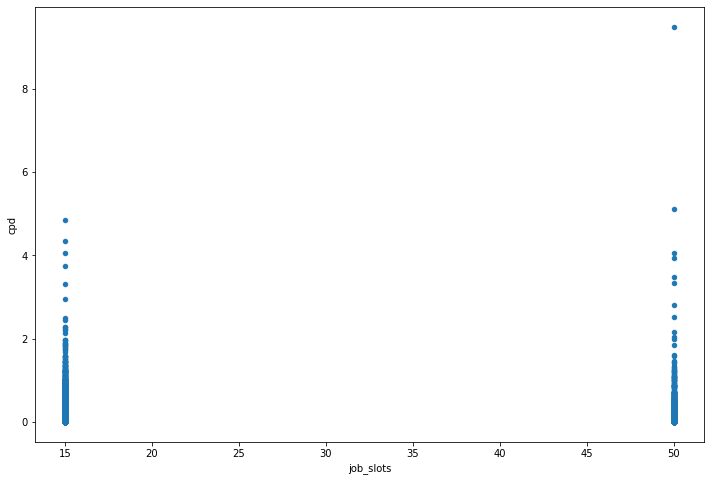

In [64]:
sp.plot.scatter(y='cpd', x='job_slots', figsize=figsize)

In [65]:
sp.groupby('job_slots').agg(mean_cpd = ('cpd', 'mean'))

,mean_cpd
job_slots,
15,0.086661
50,0.168476


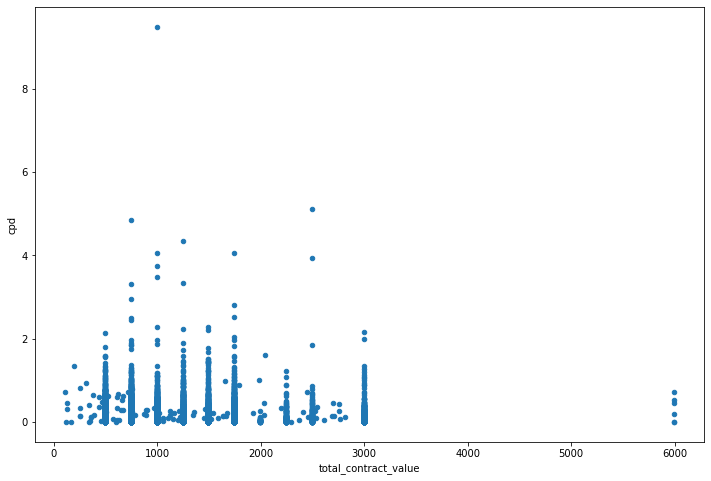

In [66]:
sp.plot.scatter(x='total_contract_value', y='cpd', figsize=figsize)

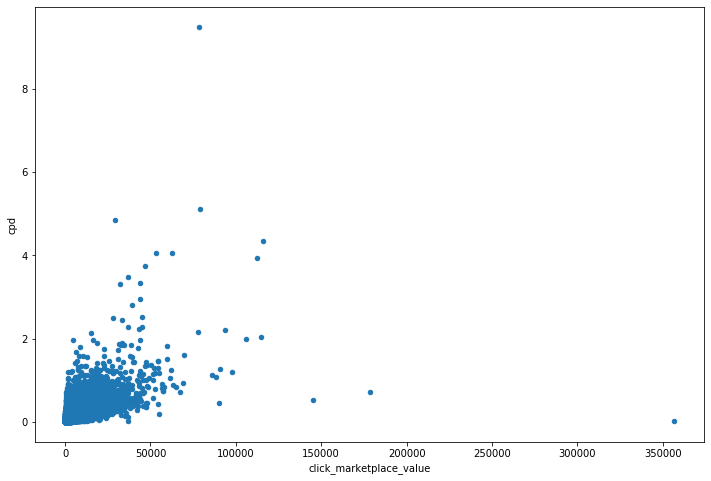

In [68]:
sp.plot.scatter(x='click_marketplace_value', y='cpd', figsize=figsize)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c40a90b50>,
      dtype=object)

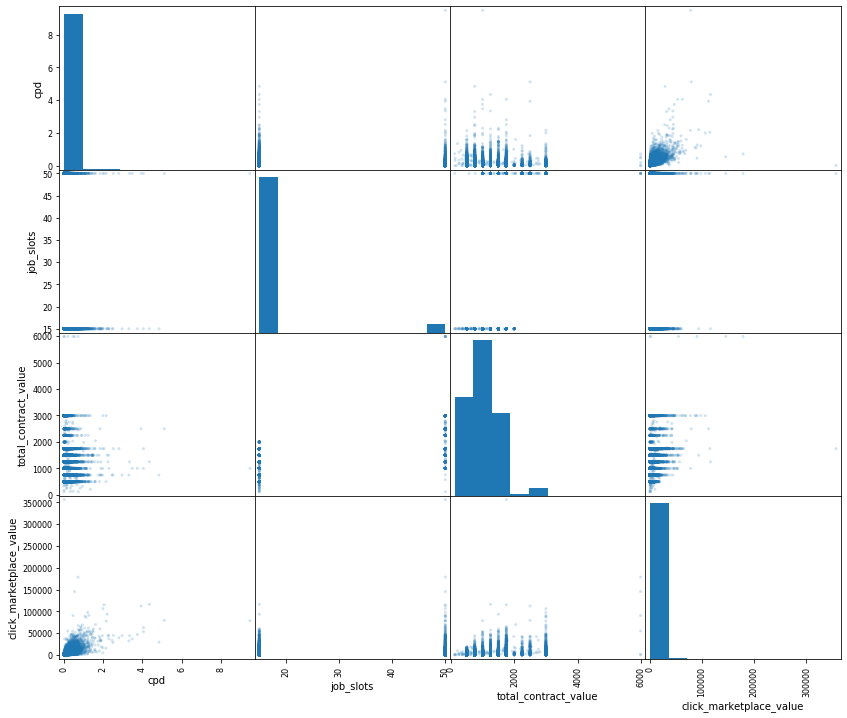

In [69]:
pd.plotting.scatter_matrix(
    sp[['cpd', 'job_slots', 'total_contract_value', 'click_marketplace_value']],
    alpha=0.2,
    figsize=(14,12)
)

In [29]:
sp

,employer_id,city_id,contract_id,start_date,end_date,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings,cpc
0,4277920,9767,2423796,2017-10-30 00:00:00,2017-11-30 00:00:00,1,15,995,215,255,15484.40,25,3.901961
1,2372987,8585,2074128,2017-06-29 00:00:00,2017-07-29 00:00:00,0,50,1495,55,70,1719.30,50,21.357143
2,1142693,6665,1924740,2017-05-02 00:00:00,2017-06-02 00:00:00,0,15,495,45,95,1195.75,20,5.210526
3,1353893,5165,1942512,2017-05-09 00:00:00,2017-06-06 00:00:00,0,15,995,155,175,1197.35,20,5.685714
4,922427,3882,1380984,2016-09-19 00:00:00,2016-10-20 00:00:00,1,15,745,150,185,8889.70,20,4.027027
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37752,5234187,123,2601276,2017-12-24 00:00:00,2018-01-11 00:00:00,0,15,1245,5,45,1846.80,0,27.666667
37753,6707680,128,2777388,2018-02-20 00:00:00,2018-03-05 00:00:00,0,15,1245,80,140,3108.40,45,8.892857
37754,1799067,7344,1128324,2016-05-28 00:00:00,2016-06-01 00:00:00,0,15,1495,35,45,949.05,0,33.222222
37755,2391600,3945,2729376,2018-02-04 00:00:00,2018-03-03 00:00:00,1,15,1245,5,5,5.00,0,249.000000


## PART C: Retention Modeling and Analysis

## Close Connection

In [ ]:
con.close()